In [6]:
# ===================================================================
# Part 1: Setup and Initialization
# ===================================================================
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import lightgbm as lgb
import nltk
import joblib
import re

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Metrics
from sklearn.metrics import classification_report, f1_score, confusion_matrix

# Environment Fixes
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

# Import our modular agent functions and feature extractor
import agent_semantic
import agent_nli

# Load spaCy and NLTK resources for feature engineering
import spacy
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
STOP_WORDS = set(stopwords.words('english'))
print("Loading spaCy model for NER...")
NLP = spacy.load("en_core_web_sm")
print("spaCy model loaded.")

print("\n--- Setup Complete ---")

Loading spaCy model for NER...
spaCy model loaded.

--- Setup Complete ---


In [7]:
# Load the pre-trained models that will generate our core features
semantic_model = agent_semantic.load_model()
nli_model = agent_nli.load_model()

Loading Semantic Analysis model (all-MiniLM-L6-v2)...
Semantic Analysis model loaded.
Loading NLI model (cross-encoder/nli-deberta-v3-xsmall)...
NLI model loaded.


In [8]:
# Load and combine both validation sets
agnostic_val_path = r'D:\Hallucination\Data\SHROOM_dev-v2\SHROOM_dev-v2\val.model-agnostic.json'
aware_val_path = r'D:\Hallucination\Data\SHROOM_dev-v2\SHROOM_dev-v2\val.model-aware.v2.json'

with open(agnostic_val_path, 'r', encoding='utf-8') as f:
    agnostic_data = json.load(f)
print(f"Loaded {len(agnostic_data)} agnostic validation data points.")

with open(aware_val_path, 'r', encoding='utf-8') as f:
    aware_data = json.load(f)
print(f"Loaded {len(aware_data)} aware validation data points.")

# The final training data is the combination of both
train_data = agnostic_data + aware_data
print(f"Total labeled data points for training: {len(train_data)}")

Loaded 499 agnostic validation data points.
Loaded 501 aware validation data points.
Total labeled data points for training: 1000


In [9]:
def extract_advanced_features(data_point):
    """
    Extracts our final, high-performance feature set from a data point.
    """
    hypothesis = data_point.get('hyp', '')
    source = data_point.get('src', '')
    target = data_point.get('tgt', '')
    task = data_point.get('task', '')

    tokens = [token.text for token in NLP(hypothesis.lower())]
    num_tokens = len(tokens) if tokens else 0
    ref_text = target if task != 'PG' else source
    
    # --- Feature Set ---
    features = {}
    features['len_hyp'] = len(hypothesis)
    features['lexical_diversity'] = len(set(tokens)) / num_tokens if num_tokens > 0 else 0
    features['length_ratio'] = len(hypothesis) / (len(ref_text) if ref_text else 1)
    
    ref_tokens_set = set(nltk.word_tokenize(ref_text.lower()))
    hyp_tokens_set = set(tokens)
    intersection = len(ref_tokens_set.intersection(hyp_tokens_set))
    union = len(ref_tokens_set.union(hyp_tokens_set))
    features['jaccard_sim'] = intersection / union if union != 0 else 0

    def get_numbers(text): return set(re.findall(r'\d+\.?\d*', text))
    features['number_mismatch'] = 1 if not get_numbers(hypothesis).issubset(get_numbers(ref_text)) else 0
    
    features['stopword_ratio'] = len([w for w in tokens if w in STOP_WORDS]) / num_tokens if num_tokens > 0 else 0
    features['avg_word_length'] = sum(len(w) for w in tokens) / num_tokens if num_tokens > 0 else 0

    doc_ref = NLP(ref_text)
    doc_hyp = NLP(hypothesis)
    entities_ref = {ent.text.lower() for ent in doc_ref.ents}
    entities_hyp = {ent.text.lower() for ent in doc_hyp.ents}
    features['new_entity_count'] = len(entities_hyp - entities_ref)
    features['entity_overlap_ratio'] = len(entities_hyp.intersection(entities_ref)) / len(entities_hyp) if len(entities_hyp) > 0 else 1.0

    return features

def generate_hybrid_features_for_df(data, semantic_model, nli_model):
    """Generates all features and returns them in a structured format for a DataFrame."""
    feature_list = []
    for dp in tqdm(data, desc="Generating All Features"):
        semantic_score = agent_semantic.get_semantic_similarity_score(dp, semantic_model)
        nli_score = agent_nli.get_nli_contradiction_score(dp, nli_model)
        
        linguistic_features = extract_advanced_features(dp)
        
        all_features = {
            'semantic_score': semantic_score,
            'nli_score': nli_score,
            **linguistic_features # Unpack the dictionary of linguistic features
        }
        feature_list.append(all_features)
    return pd.DataFrame(feature_list)

# Generate features for our training data
X_train_df = generate_hybrid_features_for_df(train_data, semantic_model, nli_model)
y_train = np.array([1 if dp['label'] == 'Hallucination' else 0 for dp in train_data])

print("\nFeature generation complete. Sample of features:")
X_train_df.head()

Generating All Features: 100%|██████████| 1000/1000 [02:13<00:00,  7.51it/s]


Feature generation complete. Sample of features:


semantic_score  nli_score  len_hyp  lexical_diversity  length_ratio  \
0        0.943080   0.001265       41                1.0      1.138889   
1        0.524881   0.057968       32                1.0     32.000000   
2        0.396081   0.067495       34                1.0      0.944444   
3        0.720085   0.005943       17                1.0      0.170000   
4        0.775952   0.010383       39                1.0      0.619048   

   jaccard_sim  number_mismatch  stopword_ratio  avg_word_length  \
0     0.363636                0        0.428571         5.142857   
1     0.000000                0        0.200000         5.600000   
2     0.357143                0        0.222222         3.222222   
3     0.250000                0        0.166667         2.500000   
4     0.583333                0        0.250000         4.250000   

   new_entity_count  entity_overlap_ratio  
0                 0                   1.0  
1                 0                   1.0  
2                 0                   1.0  
3                 0                   1.0  
4                 1                   0.5

In [10]:
# --- Define Paths for the Final Tuned Model ---
MODEL_DIR = 'tuned_model'
TUNED_MODEL_PATH = os.path.join(MODEL_DIR, 'tuned_lgbm_model.joblib')
if not os.path.exists(MODEL_DIR): os.makedirs(MODEL_DIR)

# --- The best parameters found by Optuna ---
best_params = {
    'objective': 'binary', 'metric': 'binary_logloss', 'n_estimators': 704,
    'learning_rate': 0.010814117771889063, 'num_leaves': 85, 'max_depth': 6,
    'reg_alpha': 0.9059847087336768, 'reg_lambda': 0.7004043033151797,
    'feature_fraction': 0.9456202723432793, 'bagging_fraction': 0.9654905315853703,
    'bagging_freq': 1, 'verbose': -1, 'n_jobs': -1, 'seed': 42
}

print("--- Training the Final, Tuned LightGBM Model ---")
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train_df, y_train)

print("\nFinal tuned model trained successfully.")
joblib.dump(final_model, TUNED_MODEL_PATH)
print(f"Model saved to {TUNED_MODEL_PATH}")

--- Training the Final, Tuned LightGBM Model ---

Final tuned model trained successfully.
Model saved to tuned_model\tuned_lgbm_model.joblib


In [11]:
# --- Load the official test data ---
TEST_DATA_PATH = 'D:\\Hallucination\\Data\\SHROOM_test-labeled\\SHROOM_test-labeled\\test.model-agnostic.json'
with open(TEST_DATA_PATH, 'r', encoding='utf-8') as f:
    test_data = json.load(f)
print(f"Loaded {len(test_data)} test data points for final evaluation.")

# --- Generate features for the test data ---
X_test_df = generate_hybrid_features_for_df(test_data, semantic_model, nli_model)
y_test_true_labels = [dp['label'] for dp in test_data]
y_test_pred_numeric = final_model.predict(X_test_df)
y_test_pred_labels = ["Hallucination" if p == 1 else "Not Hallucination" for p in y_test_pred_numeric]

# --- Print Final Report ---
print("\n--- FINAL TUNED MODEL Performance on Official Test Data ---")
print(classification_report(y_test_true_labels, y_test_pred_labels))
macro_f1 = f1_score(y_test_true_labels, y_test_pred_labels, average='macro')
print("=====================================================")
print(f"  FINAL TUNED MODEL Macro F1 Score: {macro_f1:.4f}")
print("=====================================================")

Loaded 1500 test data points for final evaluation.


Generating All Features: 100%|██████████| 1500/1500 [03:05<00:00,  8.08it/s]


--- FINAL TUNED MODEL Performance on Official Test Data ---
                   precision    recall  f1-score   support

    Hallucination       0.70      0.68      0.69       611
Not Hallucination       0.78      0.80      0.79       889

         accuracy                           0.75      1500
        macro avg       0.74      0.74      0.74      1500
     weighted avg       0.75      0.75      0.75      1500

  FINAL TUNED MODEL Macro F1 Score: 0.7410


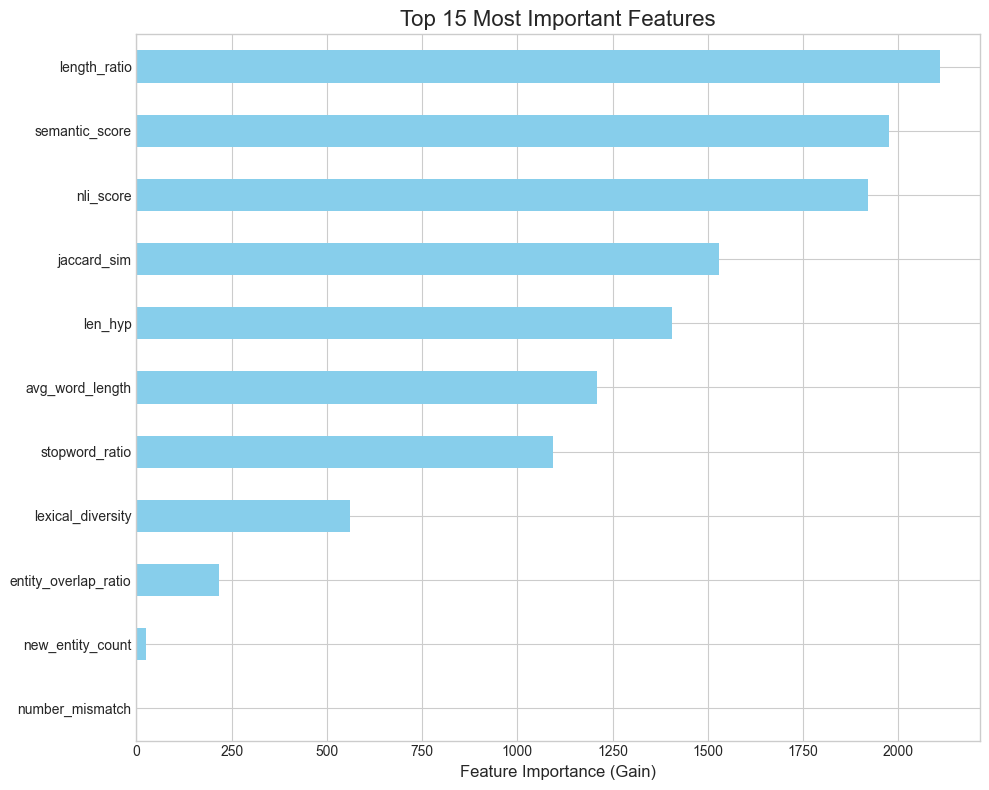

In [12]:
# --- Plot Feature Importance ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 8))

# Create a pandas series for easier plotting
feature_importances = pd.Series(final_model.feature_importances_, index=X_train_df.columns)
feature_importances.nlargest(15).sort_values().plot(kind='barh', ax=ax, color='skyblue')

ax.set_title('Top 15 Most Important Features', fontsize=16)
ax.set_xlabel('Feature Importance (Gain)', fontsize=12)
plt.tight_layout()
plt.show()

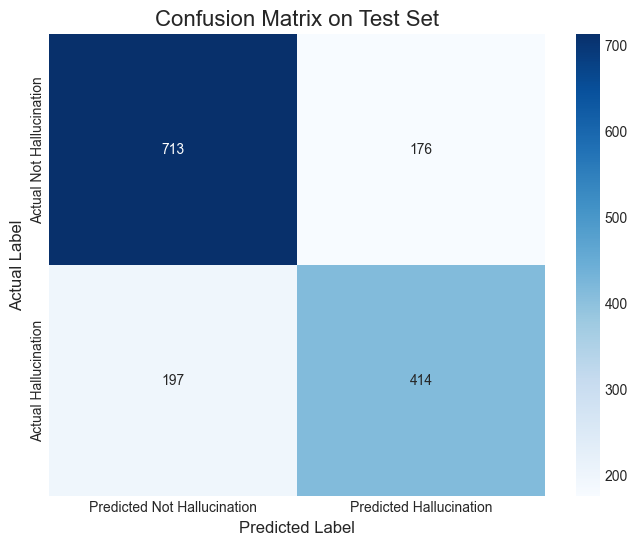

In [13]:
# --- Plot Confusion Matrix ---
cm = confusion_matrix(y_test_true_labels, y_test_pred_labels, labels=["Not Hallucination", "Hallucination"])
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=["Predicted Not Hallucination", "Predicted Hallucination"],
            yticklabels=["Actual Not Hallucination", "Actual Hallucination"])

ax.set_title('Confusion Matrix on Test Set', fontsize=16)
ax.set_ylabel('Actual Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.show()